# Import packages

In [1]:
import os
import numpy as np
# import ipdb
import time
from tqdm import tqdm
import datetime
import pandas as pd
import logging
from pathlib import Path
import matplotlib.pyplot as plt
import math

# torchvision for image loading
import torchvision
from torchvision import datasets, models
import torchvision.transforms.v2 as tr
import torchvision.transforms.v2.functional as trf

from torch.utils.data import DataLoader

# for transformations
import torchvision.transforms.v2 as tr
import torchvision.transforms.v2.functional as trf

# torch for model creation
import torch
import torch.nn as nn

# for model evaluation
import torcheval.metrics.functional as metf
from sklearn.metrics import precision_score, recall_score

#sklearn for data splitting
from sklearn.model_selection import train_test_split

import sys

sys.path.append(os.path.join(os.getcwd(), "Datasetting"))
from Setdatapred import EcoTaxaDataset, transform_vignettes_valid, FocalLoss, remove_missing_or_empty_images

sys.path.append(os.path.join(os.getcwd(), "PyramidNetPyTorch"))
from PyramidNet import PyramidNet

sys.path.append(os.path.join(os.getcwd(), "Loadingmodels"))
from Loading_models import initialize_model

sys.path.append(os.path.join(os.getcwd(), "Predictingmodels"))
from Predicting_models import predict_with_softmax

# Auto lr finding
from torch_lr_finder import LRFinder

# Import mlflow dor data visualization
import mlflow

/home/coicaudtou/.conda/envs/Classification_UVP6_py310_v2/lib/python3.10/site-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Import Data

## Config

In [2]:
# root of the project
try:
    base_dir = Path(__file__).resolve().parent
except NameError:
    base_dir = Path("/home/coicaudtou/myspace/Classify_ANERIS")

# relative folders
data_dir = base_dir / "Data"
remote_dir = "/remote/ecotaxa/vault"
tsv_path = base_dir / "Data" / "stacked_anerissmartbay_prediction.tsv"
pred_dir = base_dir / "Outputs"/ "output_prediction"
model_dir = base_dir/ "Outputs" / "output_training"
log_dir = base_dir / "Outputs" / "log"

RANDOM_STATE = 42

# prepare loggers
log = logging.getLogger()
log.setLevel(logging.INFO)

    # define the output format for log messages
log_formatter = logging.Formatter('%(asctime)s.%(msecs)03d\t%(message)s',\
                                  datefmt='%Y-%m-%dT%H:%M:%S')

    # log to console
console_handler = logging.StreamHandler()
console_handler.setFormatter(log_formatter)
log.addHandler(console_handler)

    # prepare logging to file (activated just before the training loop)
log_file = os.path.join(log_dir, 'log.tsv')
file_handler = logging.FileHandler(log_file)
file_handler.setFormatter(log_formatter)

## Load data

In [3]:
# Charger d'abord les données utilisées pendant l'entrainement
tsv_training_path = base_dir / "Data" / "stacked_anerissmartbay_training.tsv"

df_train = pd.read_csv(tsv_training_path, sep="\t", engine="python")
# Classes to exclude 
other_to_live = [
    "Trisopterus minutus",
    "reflection",
    "egg sac<egg",
    "t004",
    "Cnidaria<Metazoa",
    "Echinodermata"
]

# Classes to gather to the upper taxonomic group
recode_dict = {
    "Swima": "Annelida",
    "Syngnathiformes": "Actinopterygii",
    "Narcomedusae": "Hydrozoa",
    "Trachymedusae": "Hydrozoa",
    "Appendicularia": "house"
}

# Add to rare classes → "othertocheck"
recode_dict.update({k: "othertocheck" for k in other_to_live})

# Classes to gather
df_train["object_annotation_category"] = (
    df_train["object_annotation_category"]
        .replace(recode_dict)
)
print("Available columns :", df_train.columns.tolist())

# convert classes to integer indexes
classes = np.unique(df_train['object_annotation_category'])
class_to_idx = {cls: i for i, cls in enumerate(classes)}
idx_to_class = {i: cls for cls, i in class_to_idx.items()}

class_names = list(class_to_idx.keys())
n_classes= len(class_to_idx)

Available columns : ['img_file_name', 'img_rank', 'object_id', 'object_lat', 'object_lon', 'object_date', 'object_time', 'object_link', 'object_depth_min', 'object_depth_max', 'object_annotation_status', 'object_annotation_person_name', 'object_annotation_person_email', 'object_annotation_date', 'object_annotation_time', 'object_annotation_category', 'object_annotation_hierarchy']


In [4]:
# ---Charger les métadonnées
df = pd.read_csv(tsv_path, sep="\t", engine="python")
print("Colonnes disponibles :", df.columns.tolist())


Colonnes disponibles : ['img_file_name', 'img_rank', 'object_id', 'object_lat', 'object_lon', 'object_date', 'object_time', 'object_link', 'object_depth_min', 'object_depth_max', 'object_annotation_status', 'object_annotation_person_name', 'object_annotation_person_email', 'object_annotation_date', 'object_annotation_time', 'object_annotation_category', 'object_annotation_hierarchy', 'img.file_name', 'img.objid']


## Set data

In [5]:
# ---Setup list of paths and labels
df = df[df['img_rank'] == 100]
df_paths = [os.path.join(remote_dir, fname) for fname in df["img.file_name"]]
df_labels = df["object_annotation_category"].tolist()
df_obj_ids = df["object_id"].tolist()

# ---Define transformations
df_transform = lambda img: transform_vignettes_valid(img, data_augmentation=False)

# ---Create Datasets
df_dataset = EcoTaxaDataset(
    paths=df_paths,
    obj_ids=df_obj_ids,
    transform=df_transform
)

## Have a look at the transformation

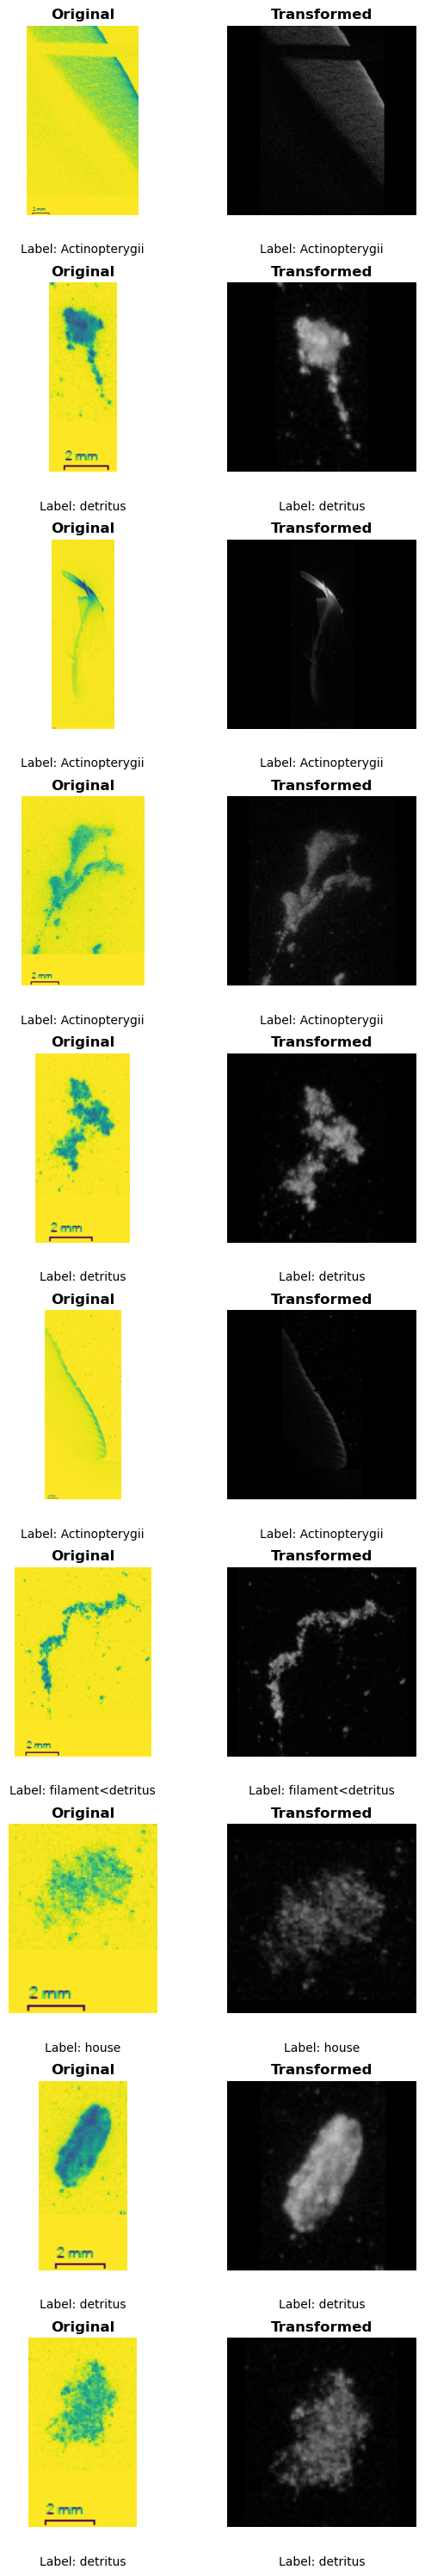

In [8]:
import matplotlib.pyplot as plt
import random
import torchvision.transforms.functional as F
from torchvision.io import read_image

# Sélection aléatoire de 10 chemins d'images
sample_df = df.sample(10, random_state=42)
sample_paths = [os.path.join(remote_dir, fname) for fname in sample_df["img.file_name"]]
sample_labels = sample_df["object_annotation_category"].tolist()
samples_obj_ids = sample_df['object_id'].tolist()

# Figure
fig, axes = plt.subplots(10, 2, figsize=(6, 30))

for i, (path, label) in enumerate(zip(sample_paths, sample_labels)):
    # Lecture de l'image brute
    img = read_image(path)
    img_before = F.to_pil_image(img)

    # Transformation
    img_after = F.to_pil_image(df_transform(img))

    # Original
    axes[i, 0].imshow(img_before)
    axes[i, 0].set_title("Original", fontsize=12, fontweight='bold')
    axes[i, 0].text(
        0.5, -0.15, f"Label: {label}",
        fontsize=10, ha='center', va='top', transform=axes[i, 0].transAxes
    )
    axes[i, 0].axis("off")

    # Transformée
    axes[i, 1].imshow(img_after)
    axes[i, 1].set_title("Transformed", fontsize=12, fontweight='bold')
    axes[i, 1].text(
        0.5, -0.15, f"Label: {label}",
        fontsize=10, ha='center', va='top', transform=axes[i, 1].transAxes
    )
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

## Dataloading

In [6]:
# ---Create Dataloaders
batch_size = 32
n_cores = 8

log.info(f'Dataloading')

df_dataloader = DataLoader(df_dataset, batch_size=batch_size, shuffle=False, num_workers=n_cores, pin_memory=True)

# ---Print infos
print(f"Nb batches : {len(df_dataloader)}")

dataloaders = {
    'df': df_dataloader
}

2025-12-18T15:39:23.086	Dataloading


Nb batches : 40503


# Start Prediction phase

In [9]:
log.info(f'Load trained model')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Initialiser le modèle
model = initialize_model(
    "efficientnet_v2", n_classes, "one_layer",
    target_params=600000,
    activation_fct=nn.Hardswish()
)
model.to(device)

# 2. CHARGER d'abord sur le bon device
ckpt_path = os.path.join(model_dir, "Final_training_smartbay_efficientnet_v2.pt")
state_dict = torch.load(ckpt_path, map_location=device)  # ✓ Déjà correct

# 3. Charger les poids
model.load_state_dict(state_dict)

# Vérifier que c'est bien sur GPU
print(f"Model device: {next(model.parameters()).device}")

df_pred = predict_with_softmax(
    model=model,
    dataloader=df_dataloader,
    device=device,
    idx_to_class=idx_to_class,
    pred_dir = pred_dir,
    output_csv="predictions_smartbay_total.csv"
)

2025-12-18T15:39:47.433	Load trained model
/tmp/ipykernel_2051913/2595819266.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(ckpt_path, map_loca

Model device: cuda:0
[OK] Predictions saved in predictions_smartbay_total.csv
